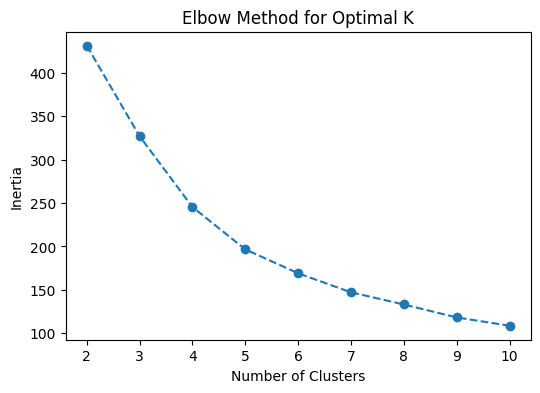

Davies-Bouldin Index: 0.9323 (Lower is better)


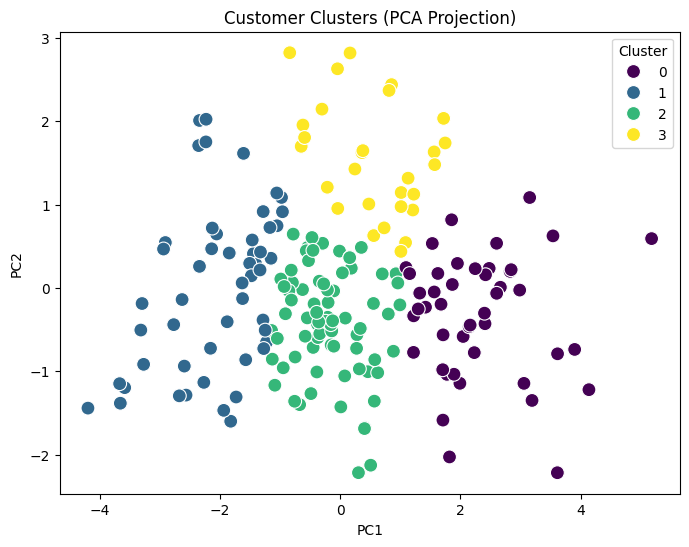

✅ Customer Segmentation Completed! Report saved as Karan_Punwatkar_Clustering.pdf


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA

# ---------------------- 1️⃣ LOAD & MERGE DATA ---------------------- #
# Load datasets
customers = pd.read_csv("../data/Customers.csv")
transactions = pd.read_csv("../data/Transactions.csv")

# Convert TransactionDate to datetime
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Aggregate transaction data per customer
customer_txn = transactions.groupby("CustomerID").agg(
    Total_Spend=('TotalValue', 'sum'),  # Total money spent
    Avg_Spend=('TotalValue', 'mean'),   # Average spend per transaction
    Num_Transactions=('TransactionID', 'count'),  # Number of transactions
    Total_Quantity=('Quantity', 'sum')  # Total quantity bought
).reset_index()

# Merge with customer details
df = pd.merge(customers, customer_txn, on="CustomerID", how="left").fillna(0)

# ---------------------- 2️⃣ FEATURE ENGINEERING ---------------------- #
# Encode categorical data (Region) using one-hot encoding
df = pd.get_dummies(df, columns=['Region'], drop_first=True)

# Selecting relevant features
features = ['Total_Spend', 'Avg_Spend', 'Num_Transactions', 'Total_Quantity']

# Standardizing the features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# ---------------------- 3️⃣ APPLY CLUSTERING (K-Means) ---------------------- #
# Find the optimal number of clusters (Elbow Method)
inertia = []
K_range = range(2, 11)  # From 2 to 10 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df[features])
    inertia.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertia, marker="o", linestyle="--")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# Choose the best K (manually from the elbow plot)
optimal_k = 4  # Change based on the Elbow plot result

# Train K-Means with optimal K
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df[features])

# ---------------------- 4️⃣ EVALUATE CLUSTERING PERFORMANCE ---------------------- #
db_index = davies_bouldin_score(df[features], df["Cluster"])
print(f"Davies-Bouldin Index: {db_index:.4f} (Lower is better)")

# ---------------------- 5️⃣ VISUALIZE CLUSTERS ---------------------- #
# Reduce dimensions using PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df[features])

# Create a DataFrame for visualization
df_vis = pd.DataFrame(df_pca, columns=["PC1", "PC2"])
df_vis["Cluster"] = df["Cluster"]

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_vis, x="PC1", y="PC2", hue="Cluster", palette="viridis", s=100)
plt.title("Customer Clusters (PCA Projection)")
plt.show()

# ---------------------- 6️⃣ SAVE OUTPUT REPORT ---------------------- #
report_text = f"""
Customer Segmentation Results:
- Optimal Clusters: {optimal_k}
- Davies-Bouldin Index: {db_index:.4f}
- Each cluster represents similar spending and purchase behavior.
"""

with open("../reports/Karan_Punwatkar_Clustering.pdf", "w") as f:
    f.write(report_text)

print("✅ Customer Segmentation Completed! Report saved as Karan_Punwatkar_Clustering.pdf")
